In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!nvidia-smi

Fri Sep 13 22:10:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [38]:
# !pip install torchsampler
# !pip install lightning
!pip install focal_loss_torch

In [12]:
""" IMPORT LIBRARIES FOR THIS PROJECT : BASIC PRACTICE """

# import the PyTorch library and its APIs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
from torchvision.transforms import v2

# Data Science
import pandas as pd # Dataframe APIs
import numpy as np # Math APIs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Image processing
from PIL import Image # Pillow for image processing
import cv2 # OpenCV
import albumentations as A # for image processing
from albumentations.pytorch import ToTensorV2
from skimage import io, transform

# Utility Libraries
import os, sys # system operations
import glob # file operations
import math # normal math function
import json # json file reader and editor
import shutil # file operations
import random # random function
from tqdm import tqdm # Progress bar APIs

from joblib import Parallel, delayed # Parallel works
from  pathlib import Path # Path variable
from pprint import pprint # Pretty print

%matplotlib inline


In [229]:
class CFG :
    # Model configuration variables
    DS_PATH = '/kaggle/input/siim-png-images'
    IMAGE_SIZE = 380 # resize image to this shape
    BATCH_SIZE = 32 # Batch size
    LR = 5e-4 # Learning rate
    NUM_WORKERS = 4
    NUM_CLASSES = 1 # define number of classes
    ACC_STEPS = 1 # gradient accumulation steps
    MAX_EPOCH = 50 # number of epochs to train the model

    WEIGHT_DIR = "/kaggle/working/weights"

In [230]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')   # train on the GPU or on the CPU, if a GPU is not available
device

device(type='cuda')

In [231]:
# the training transforms
train_transform = A.Compose([
    A.Resize(height=int(CFG.IMAGE_SIZE*1.2), width=int(CFG.IMAGE_SIZE*1.2)),  # Increased size for better detail preservation
    A.OneOf([
        A.RandomResizedCrop(height=CFG.IMAGE_SIZE, width=CFG.IMAGE_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5),
        A.CenterCrop(height=CFG.IMAGE_SIZE, width=CFG.IMAGE_SIZE, p=0.5),
    ], p=1.0),  # Crop to focus on different parts of the lung
    A.Rotate(limit=10, p=0.5),  # Slight rotation to simulate patient positioning variations
    A.HorizontalFlip(p=0.5),  # Horizontal flip to augment data
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.8),
    ], p=1.0),  # Enhance contrast and brightness, important for X-ray images
    A.GaussNoise(var_limit=(0, 25.0), mean=0, p=0.5),  # Simulate image noise
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),  # Slight blur to simulate lower quality scans
    A.ElasticTransform(alpha=1, sigma=50, p=0.3),  # Simulate subtle tissue deformations
    A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.3),  # Simulate subtle tissue distortions
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for pretrained models
    ToTensorV2(),
])
# the validation v2
valid_transform = A.Compose([
    A.Resize(height=int(CFG.IMAGE_SIZE*1.2), width=int(CFG.IMAGE_SIZE*1.2)),  # Increased size for better detail preservation
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize for pretrained models
    ToTensorV2(),
])

In [232]:
df = pd.read_csv('/kaggle/input/siim-train-dataframe/train.csv')
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.shape, valid_df.shape

((9265, 2), (2317, 2))

In [233]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None):
        """
        Args:
            dataframe (pandas.DataFrame): DataFrame containing 'ImageId' and 'Class' columns
            img_dir (string): Directory with all the images
            transform (callable, optional): Optional transform to be applied on an image
            target_transform (callable, optional): Optional transform to be applied on the target
        """
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.labels = dataframe.Class.tolist()

    def __len__(self):
        return len(self.img_labels)

    def get_labels(self):
        return self.labels
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) + '.png'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image=image)["image"]
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [234]:
train_dataset = CustomImageDataset(dataframe=train_df,
                                   img_dir=CFG.DS_PATH+'/train_png' ,
                                   transform=train_transform
                                  )
valid_dataset = CustomImageDataset(dataframe=valid_df,
                                   img_dir=CFG.DS_PATH+'/train_png',
                                   transform=valid_transform
                                  )

In [235]:
len(train_dataset),  len(valid_dataset)

(9265, 2317)

In [236]:
from torchsampler import ImbalancedDatasetSampler
# training data loaders
train_loader = DataLoader(
    train_dataset,
    sampler=ImbalancedDatasetSampler(train_dataset),
    batch_size=CFG.BATCH_SIZE, 
    num_workers=CFG.NUM_WORKERS, 
    shuffle=False,
    pin_memory=True
)
# validation data loaders
valid_loader = DataLoader(
    valid_dataset, 
    batch_size=CFG.BATCH_SIZE, 
    num_workers=CFG.NUM_WORKERS, 
    shuffle=False,
    pin_memory=True
)

In [237]:
next(iter(train_loader))

[tensor([[[[-0.4397, -0.5424, -0.6452,  ..., -1.5528, -1.5528, -1.5528],
           [-0.3541, -0.5938, -0.5424,  ..., -1.5357, -1.5357, -1.5357],
           [-0.3198, -0.3198, -0.3883,  ..., -1.5357, -1.4843, -1.5357],
           ...,
           [-0.7993, -0.7822, -0.7308,  ..., -0.8678, -0.9020, -0.9363],
           [-0.7993, -0.7308, -0.6965,  ..., -0.7993, -0.9020, -0.9020],
           [-0.8335, -0.7993, -0.7822,  ..., -0.7993, -0.9363, -0.8678]],
 
          [[-0.3200, -0.4251, -0.5301,  ..., -1.4580, -1.4580, -1.4580],
           [-0.2325, -0.4776, -0.4251,  ..., -1.4405, -1.4405, -1.4405],
           [-0.1975, -0.1975, -0.2675,  ..., -1.4405, -1.3704, -1.4405],
           ...,
           [-0.6877, -0.6702, -0.6176,  ..., -0.7577, -0.7927, -0.8277],
           [-0.6877, -0.6176, -0.5826,  ..., -0.6877, -0.7927, -0.7927],
           [-0.7227, -0.6877, -0.6702,  ..., -0.6877, -0.8277, -0.7577]],
 
          [[-0.0964, -0.2010, -0.3055,  ..., -1.2293, -1.2293, -1.2293],
           [-

In [238]:
# Function to plot a grid of images and their labels
def plot_grid(dataloader, classes, num_images=16):
    """Plots a grid of images from the dataloader with labels."""
    images, labels = next(iter(dataloader))  # Get a batch from the dataloader
    images = images[:num_images]  # Select the first num_images images
    labels = labels[:num_images]  # Select corresponding labels
    
    # Create a grid of images
    grid_img = torchvision.utils.make_grid(images, nrow=4, padding=2, normalize=True)

    # Convert the grid of tensors to a NumPy array for plotting
    np_grid_img = grid_img.permute(1, 2, 0).cpu().numpy()

    # Plot the grid of images
    plt.figure(figsize=(10, 10))
    plt.imshow(np_grid_img)  # Use the NumPy array
    plt.title("Sample Images with Labels")
    plt.axis("off")
    
    # Display corresponding labels
    label_text = [classes[label.item()] for label in labels]
    print("Labels:", label_text)
    
    plt.show()

Labels: ['Pneumothorax', 'Pneumothorax', 'Pneumothorax', 'Pneumothorax', 'Normal', 'Normal', 'Pneumothorax', 'Pneumothorax', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Pneumothorax', 'Pneumothorax']


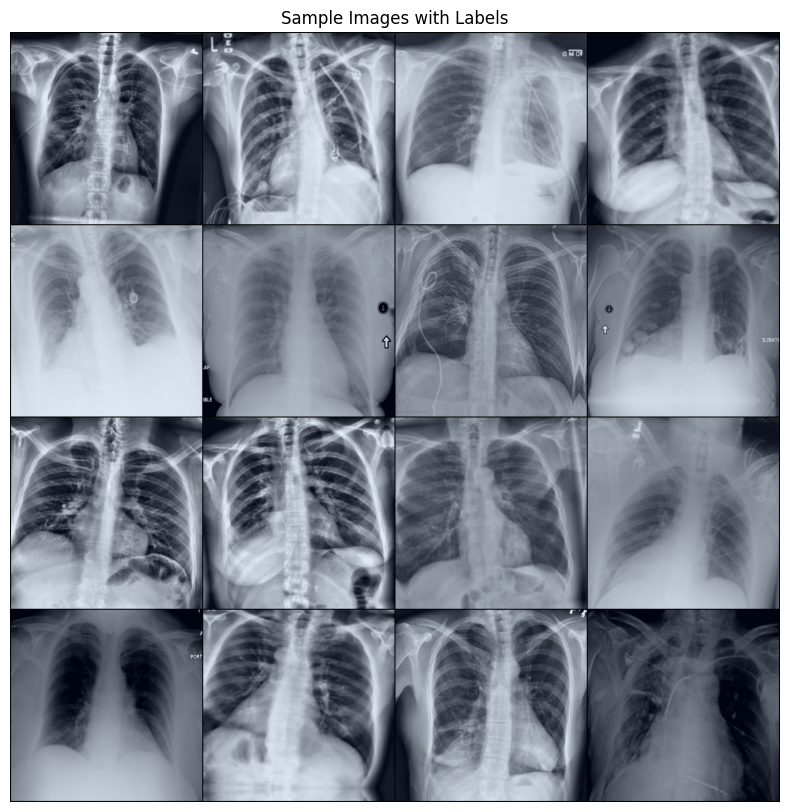

In [239]:
class_names = ["Normal", "Pneumothorax"]
plot_grid(train_loader, class_names)

In [263]:
# IMPORT PYTORCH LIGHTNING LIBRARY APIs
import lightning as L
from pytorch_lightning.utilities.types import STEP_OUTPUT
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # APIs for new MRCNN head
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor # APIs for new MRCNN head
import torchvision.models.segmentation # load segmentation model APIs
from torchmetrics.detection.mean_ap import MeanAveragePrecision # evaluation metrics mAP
from lightning.pytorch.callbacks import ( # applying early stop to our model
                                         ModelCheckpoint, # save model
                                         LearningRateMonitor,
                                         ) # callback functions
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from pytorch_lightning.loggers import TensorBoardLogger # Monitoring
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR # learning rate schduler

from lightning.pytorch.utilities.memory import recursive_detach
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
import timm
from focal_loss.focal_loss import FocalLoss


class cnnModel(L.LightningModule):
    def __init__(
        self,
        model_name="timm/tf_efficientnet_b4.ns_jft_in1k",
        learning_rate=1e-4,
        num_classes=1,
        ):
        super().__init__()

        self.learning_rate = learning_rate
        self.num_classes = num_classes

        # Load a pre-trained model from timm
        self.model = timm.create_model(model_name, pretrained=True)
        num_in_features = self.model.get_classifier().in_features

        ################# New Head ########################
        self.model.classifier = nn.Sequential(
                    nn.Dropout(0.25),  # Move dropout before batch norm for potential regularization
                    nn.Linear(in_features=num_in_features, out_features=512, bias=False),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(0.25),
                    nn.Linear(in_features=512, out_features=self.num_classes, bias=False)
                    )# modify classify's head



        # Loss function for binary classification
        self.loss_fn = nn.BCEWithLogitsLoss()


        # Define binary metrics for training and validation
        metrics = MetricCollection({
            'accuracy': BinaryAccuracy(),
            'precision': BinaryPrecision(),
            'recall': BinaryRecall(),
            'f1': BinaryF1Score()
        })


        self.train_metrics = metrics.clone(prefix='train_')
        self.valid_metrics = metrics.clone(prefix='valid_')

        self.save_hyperparameters() # tell the model to save the hyperparameters into the checkpoint file

    def forward(self, x):
        return self.model(x)


    def training_step(self, batch, batch_idx) :
        """return loss from our training process

        Args:
            batch (tuple): (images, targets)
            batch_idx (int): the index of the current batch

        Returns:
            loss : sum of the loss dict that we got from our model
        """
        x, y = batch
        logits = self.forward(x)

        # Calculate binary loss
        loss = self.loss_fn(logits.view(-1), y.float())  # BCE expects float targets

        # Compute training metrics
        metric_outputs = self.train_metrics(logits.view(-1), y)
        self.log_dict({'train_loss': loss, **metric_outputs}, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        
        # Calculate binary loss
        loss = self.loss_fn(logits.view(-1), y.float())

        # Update validation metrics
        self.valid_metrics.update(logits.view(-1), y)
        self.log_dict({'valid_loss': loss}, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss

    def on_validation_epoch_end(self):
        # Compute and log validation metrics at the end of each epoch
        output = self.valid_metrics.compute()
        self.log_dict(output, prog_bar=True)
        self.valid_metrics.reset()



    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        
        # Calculate test loss
        loss = self.loss_fn(logits.view(-1), y.float())
        self.log("test_loss", loss)


    def predict_step(self, batch, batch_idx):
        x, _ = batch
        return torch.sigmoid(self.forward(x))  # Sigmoid for probability prediction

    def configure_optimizers(self):
        # AdamW optimizer with a ReduceLROnPlateau scheduler
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "valid_loss",  # Monitor validation loss to reduce learning rate
            }
        }




In [265]:
model = cnnModel("timm/tf_efficientnet_b4.ns_jft_in1k",CFG.LR, CFG.NUM_CLASSES)

In [266]:
early_stop_callback = EarlyStopping(
    monitor="valid_loss",
    patience=5,
    mode="min",
    # min_delta=0.02,
    verbose=True,
)
early_stop_callback

In [267]:
checkpoint_callback = ModelCheckpoint(
    dirpath=CFG.WEIGHT_DIR,
    monitor="valid_loss",
    mode="min", # setting the checkpoint to minimize the loss
    filename="timm/tf_efficientnet_b4.ns_jft_in1k_{valid_loss}_{valid_accuracy}",
    save_top_k=1, # save best model
    verbose=True, # report
)
checkpoint_callback

In [268]:
from lightning.pytorch.callbacks import LearningRateMonitor
lr_monitor = LearningRateMonitor(logging_interval='epoch')
lr_monitor

In [271]:
trainer = L.Trainer(
    accelerator="gpu",
    fast_dev_run=False,
    precision='16-mixed',
    min_epochs=1,
    max_epochs= CFG.MAX_EPOCH,
    # overfit_batches=1,
    # accumulate_grad_batches = 4,
    # gradient_clip_val=0.5,
    callbacks=[
          early_stop_callback,
          checkpoint_callback,
          lr_monitor
              ],
              )


In [272]:
trainer.fit(model, train_loader, valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | model         | EfficientNet      | 18.5 M | train
1 | loss_fn       | BCEWithLogitsLoss | 0      | train
2 | train_metrics | MetricCollection  | 0      | train
3 | valid_metrics | MetricCollection  | 0      | train
------------------------------------------------------------
18.5 M    Trainable params
0         Non-trainable params
18.5 M    Total params
73.871    Total estimated model params size (MB)
670       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved. New best score: 0.309


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.296


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.287


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.279


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.268


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.263


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric valid_loss did not improve in the last 5 records. Best score: 0.263. Signaling Trainer to stop.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 0.9007
Precision: 0.8697
Recall: 0.7807
F1 Score: 0.8228


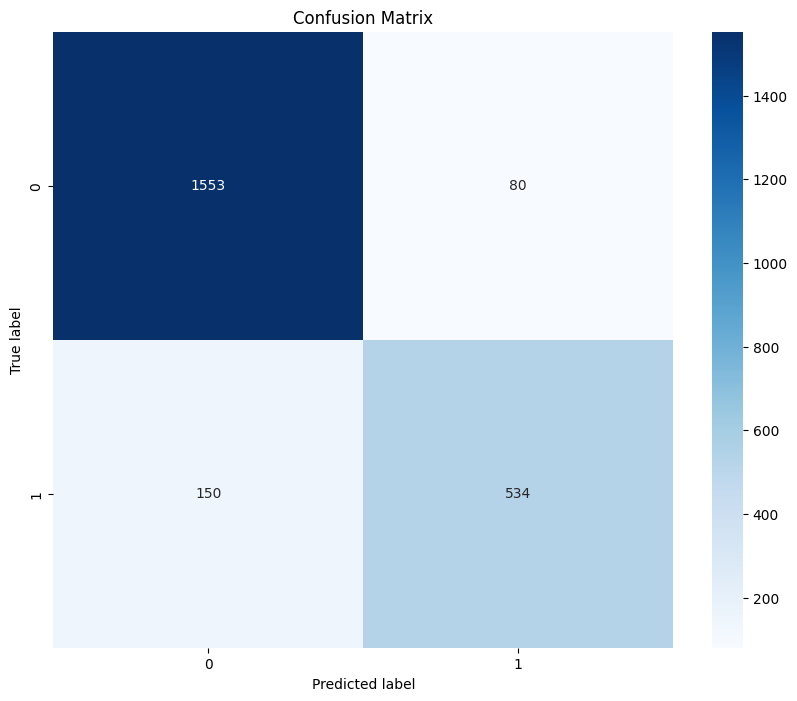

In [278]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

def validate_model(model, test_dataloader, device):
    model.eval()
    model.to(device)

    # Initialize metrics
    accuracy = BinaryAccuracy().to(device)
    precision = BinaryPrecision().to(device)
    recall = BinaryRecall().to(device)
    f1_score = BinaryF1Score().to(device)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in test_dataloader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            logits = model(x)
            preds = torch.sigmoid(logits.view(-1)) > 0.7

            # Update metrics
            accuracy(preds, y)
            precision(preds, y)
            recall(preds, y)
            f1_score(preds, y)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    # Compute final metrics
    acc = accuracy.compute()
    prec = precision.compute()
    rec = recall.compute()
    f1 = f1_score.compute()

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnnModel.load_from_checkpoint("/kaggle/working/weights/timm/tf_efficientnet_b4.ns_jft_in1k_valid_loss=0.26302555203437805_valid_accuracy=0.9011653065681458.ckpt")
validate_model(model, valid_loader, device)

In [276]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/